## Face Recognition

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import model_selection
import glob
import tqdm

In [10]:
! mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:00<00:00, 25.2MB/s]
100% 1.33G/1.33G [01:00<00:00, 23.7MB/s]


In [ ]:
!unzip /content/celeba-dataset.zip

In [13]:
def make_pair (folder_path):
  files_list = glob.glob(folder_path+'/*.jpg')
  files_list_1 = []
  files_list_2 = []
  target_list = []

  for path in tqdm.tqdm(files_list):
    files_list_1.append(path)
    files_list_2.append(path)
    target_list.append(1)

    while True:
      n = np.random.randint(low=0, high= len(files_list))
      if path != files_list[n]:
        files_list_1.append(path)
        files_list_2.append(files_list[n])
        target_list.append(0)
        break

  data_dic = {
      'image_1': files_list_1,
      'image_2': files_list_2,
      'labels': target_list
  }

  dataset = pd.DataFrame(data_dic)

  return dataset


In [14]:
df = make_pair('/content/img_align_celeba/img_align_celeba').iloc[:10000]
df

100%|██████████| 202599/202599 [00:00<00:00, 249725.17it/s]


,image_1,image_2,labels
0,/content/img_align_celeba/img_align_celeba/019...,/content/img_align_celeba/img_align_celeba/019...,1
1,/content/img_align_celeba/img_align_celeba/019...,/content/img_align_celeba/img_align_celeba/108...,0
2,/content/img_align_celeba/img_align_celeba/020...,/content/img_align_celeba/img_align_celeba/020...,1
3,/content/img_align_celeba/img_align_celeba/020...,/content/img_align_celeba/img_align_celeba/139...,0
4,/content/img_align_celeba/img_align_celeba/011...,/content/img_align_celeba/img_align_celeba/011...,1
...,...,...,...
9995,/content/img_align_celeba/img_align_celeba/202...,/content/img_align_celeba/img_align_celeba/051...,0
9996,/content/img_align_celeba/img_align_celeba/171...,/content/img_align_celeba/img_align_celeba/171...,1
9997,/content/img_align_celeba/img_align_celeba/171...,/content/img_align_celeba/img_align_celeba/038...,0
9998,/content/img_align_celeba/img_align_celeba/162...,/content/img_align_celeba/img_align_celeba/162...,1


In [15]:
train, test = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df.labels)

train.shape, test.shape

((9000, 3), (1000, 3))

In [16]:
def read_image(x, y):
  x1 , x2 = x
  x1 = tf.io.read_file(x1)
  x1 = tf.image.decode_jpeg(x1, channels=3)
  x1 = tf.image.convert_image_dtype(x1, tf.float32)
  x1 = tf.image.resize(x1, (244, 244))
  x1 = tf.clip_by_value(x1, 0.0, 0.1)

  x2 = tf.io.read_file(x2)
  x2 = tf.image.decode_jpeg(x2, channels=3)
  x2 = tf.image.convert_image_dtype(x2, tf.float32)
  x2 = tf.image.resize(x2, (244, 244))
  x2 = tf.clip_by_value(x2, 0.0, 0.1)

  return (x1,x2) , y


In [17]:
def augment_image(x, y):
  x1 , x2 = x

  x1= tf.image.random_flip_left_right(x1)
  x1= tf.image.random_brightness(x1, 32.0/255.0)
  x1= tf.image.random_saturation(x1, 0.5, 1.5)

  x2= tf.image.random_flip_left_right(x2)
  x2= tf.image.random_brightness(x2, 32.0/255.0)
  x2= tf.image.random_saturation(x2, 0.5, 1.5)

  return (x1,x2), y

In [18]:
def celebs_dataset(x1,x2 , y, batch_size=32, training=False):
  data = tf.data.Dataset.from_tensor_slices(((x1,x2), y))
  data = data.shuffle(1024)
  data = data.map(read_image, num_parallel_calls= tf.data.experimental.AUTOTUNE)

  if training:
    data = data.map(augment_image, num_parallel_calls= tf.data.experimental.AUTOTUNE)

  data = data.batch(batch_size)
  data = data.prefetch(tf.data.experimental.AUTOTUNE)

  return data

train_dataset = celebs_dataset(train.image_1,train.image_2, train.labels, training=True )
test_dataset = celebs_dataset(test.image_1,test.image_2, test.labels )

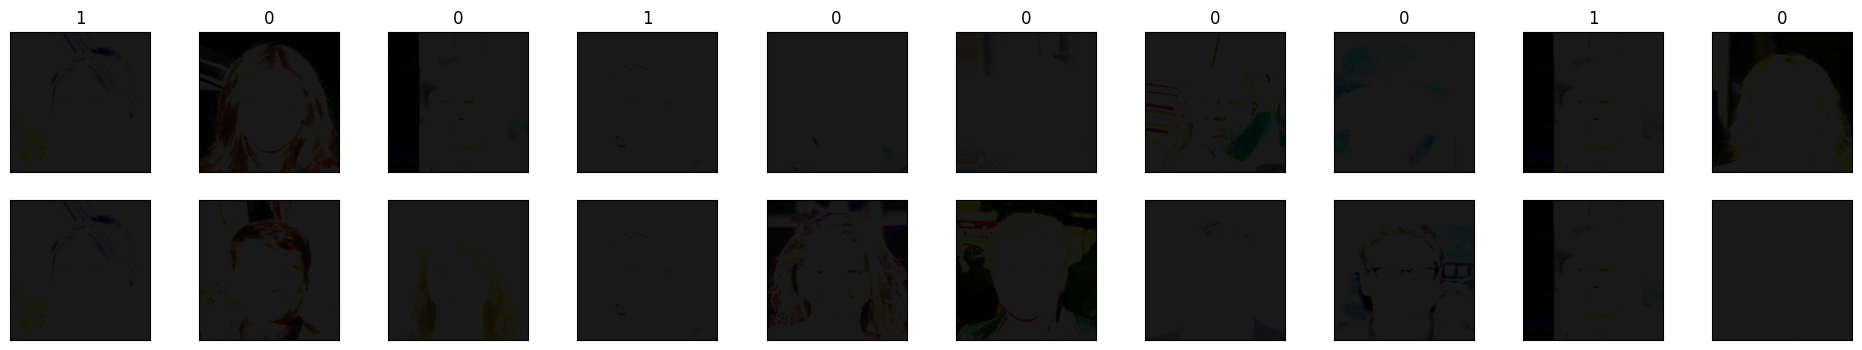

In [19]:
plt.figure(figsize=(24, 4))

for x, y in test_dataset.take(1) :
  x1, x2 = x
  for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.title(f'{y[i]}')
    plt.imshow(tf.squeeze(x1[i]))
    plt.gray()
    plt.xticks([])
    plt.yticks([])



    plt.subplot(2, 10, 10+i+1)
    plt.imshow(tf.squeeze(x2[i]))
    plt.xticks([])
    plt.yticks([])


In [ ]:
dense_model = tf.keras.applications.DenseNet121(
    include_top=False,
    input_shape=(244, 244, 3),
)
dense_model.trainable = False
dense_model.summary()

In [30]:
class   SiamesModel(tf.keras.Model):
  def __init__(self, dense_model):
     super(SiamesModel, self).__init__()

     self.dense_model = dense_model
     self.d1 = tf.keras.layers.Dense(units=512, use_bias=False)
     self.bn1 = tf.keras.layers.BatchNormalization()
     self.d2 = tf.keras.layers.Dense(units=512, use_bias=False)
     self.bn2 = tf.keras.layers.BatchNormalization()
     self.out = tf.keras.layers.Dense(units=1, activation='sigmoid')


  def call(self, inputs):
    x1, x2 = inputs
    x1= self.dense_model(x1)
    x1= tf.keras.layers.GlobalAveragePooling2D()(x1)
    x2= self.dense_model(x2)
    x2= tf.keras.layers.GlobalAveragePooling2D()(x2)

    x=tf.keras.layers.concatenate([x1 ,x2])
    x = self.d1(x)
    x = self.bn1(x)
    x= tf.nn.leaky_relu(x)
    x = self.d2(x)
    x = self.bn2(x)
    x= tf.nn.leaky_relu(x)
    output = self.out(x)
    return output

  def build_model(self,dim=[244, 244, 3]):
    x= (tf.keras.layers.Input(dim), tf.keras.layers.Input(dim))
    return tf.keras.Model(inputs=[x], outputs=[self.call(x)])

model = SiamesModel(dense_model)
model.build_model().summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 244, 244, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 7, 7, 1024)           7037504   ['input_15[0][0]',            
                                                                     'input_16[0][0]']            
                                                                                                  
 global_average_pooling2d_1  (None, 1024)                 0         ['densenet121[0][0]']   

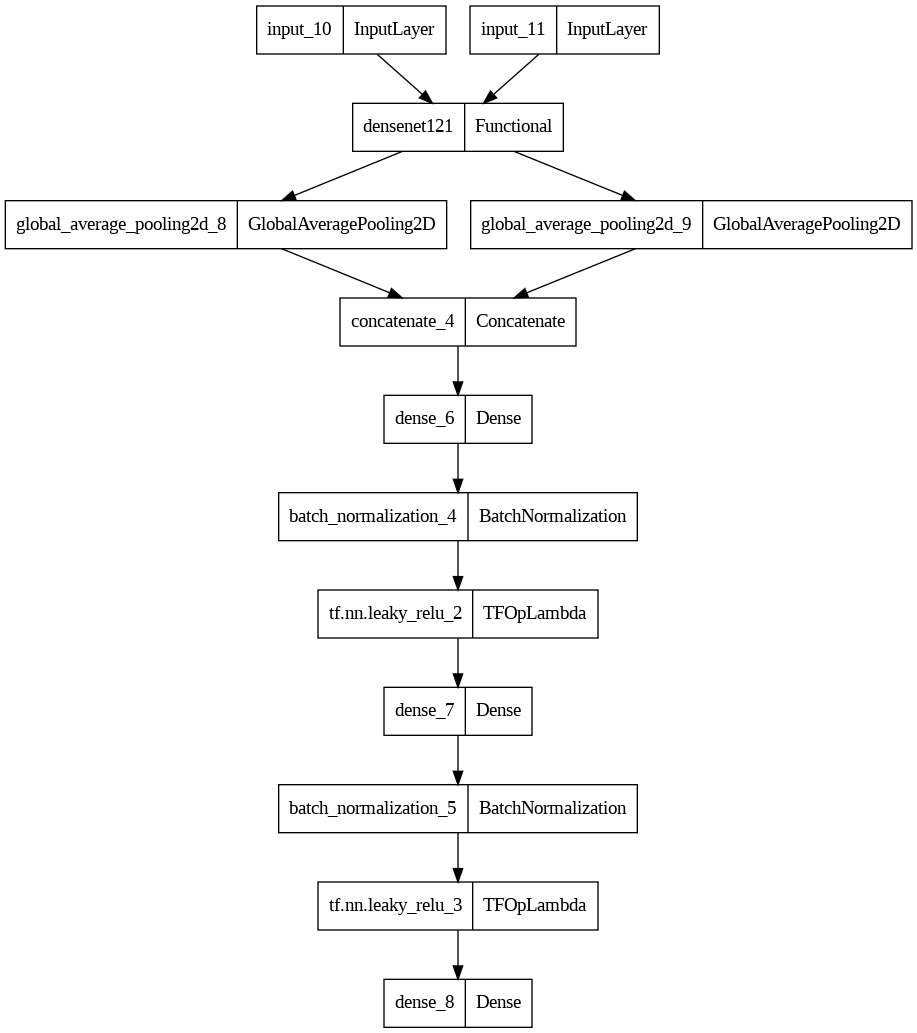

In [26]:
  tf.keras.utils.plot_model(model.build_model())

In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics= ['acc']
              )
model.fit(train_dataset, epochs=2, validation_data=test_dataset )

Epoch 1/2
282/282 [==============================] - 87s 255ms/step - loss: 0.2761 - acc: 0.8843 - val_loss: 0.1437 - val_acc: 0.9480
Epoch 2/2
282/282 [==============================] - 71s 253ms/step - loss: 0.2360 - acc: 0.9056 - val_loss: 0.1079 - val_acc: 0.9680
